# Neuroevolution with NEAT

We will start by installing the ```neat-python``` library, which provides an implementation of NEAT, and the ```networkx``` library to draw the resulting network

In [ ]:
%pip install neat-python

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.5 MB/s eta 0:00:005.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
import neat
import random
import networkx as nx

The problem is a variant of the XOR problem with one additional input.

We have three inputs $x_1, x_2, x_3$ and two outputs $y_1 = x_1 \oplus x_2$ and $y_2 = \neg x_3$.

Part of the following code is adapted from a ```neat-python``` example

In [7]:
xor_inputs = [(0.0, 0.0, 0.0), (0.0, 0.0, 1.0),
              (0.0, 1.0, 0.0), (0.0, 1.0, 1.0),
              (1.0, 0.0, 0.0), (1.0, 0.0, 1.0),
              (1.0, 1.0, 0.0), (1.0, 1.0, 1.0)]
xor_outputs = [(0.0, 1.0), (0.0, 0.0),
               (1.0, 1.0), (1.0, 0.0),
               (1.0, 1.0), (1.0, 0.0),
               (0.0, 1.0), (0.0, 0.0)]

To define how to eval the genomes we generate the network starting from the genome using ```nn.FeedFOrwardNetwork.create```, and we can use the method ```activate``` to compute the outputs of the net.

In [8]:
# We need a way to evaluate the fitness of the genomes.
# The fitness function is called for a set of genome in the population on to some config file.

def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 16.0  # We start with saying 16 correct outputs
        net = neat.nn.FeedForwardNetwork.create(genome, config)  # Create a neural network from the configuration 
        for xi, xo in zip(xor_inputs, xor_outputs):  # For each input and output pair we compute the MSE
            output = net.activate(xi)
            genome.fitness -= (output[0] - xo[0]) ** 2
            genome.fitness -= (output[1] - xo[1]) ** 2

The ```neat-python``` library **requires** a (non-trivial) configuration file (see ```neat_config.txt```)

In [10]:
config = neat.Config(neat.genome.DefaultGenome,
                     neat.reproduction.DefaultReproduction,
                     neat.species.DefaultSpeciesSet,
                     neat.stagnation.DefaultStagnation,
                     "neat_config.txt")

We can now create the initial population (based on the given configuration)

In [11]:
population = neat.Population(config)

We evolve the population from $500$ generations

In [13]:
random.seed(0)
winner = population.run(eval_genomes, 500)

We can print the best network found:

In [14]:
print(f'Best genome:\n{winner}')

Best genome:
Key: 36633
Fitness: 15.95923032652701
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.841197123597861, response=1.0, activation=sigmoid, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=5.793707202067432, response=1.0, activation=sigmoid, aggregation=sum)
	3468 DefaultNodeGene(key=3468, bias=-0.6452409520774406, response=1.0, activation=sigmoid, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-3, 1), weight=-18.669444832766587, enabled=True)
	DefaultConnectionGene(key=(-2, 0), weight=-1.0704853112467634, enabled=True)
	DefaultConnectionGene(key=(-2, 3468), weight=1.8996819615507707, enabled=True)
	DefaultConnectionGene(key=(-1, 0), weight=1.511542894378222, enabled=True)
	DefaultConnectionGene(key=(-1, 3468), weight=-4.009311461995168, enabled=True)
	DefaultConnectionGene(key=(3468, 0), weight=8.563047497638681, enabled=True)


And the outputs of the network:

In [15]:
print('\nOutput:')
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
for xi, xo in zip(xor_inputs, xor_outputs):
    output = winner_net.activate(xi)
    print(f"input {xi}, expected output {xo}, got {output}")


Output:
input (0.0, 0.0, 0.0), expected output (0.0, 1.0), got [0.07104075078184773, 0.9999999999997375]
input (0.0, 0.0, 1.0), expected output (0.0, 0.0), got [0.07104075078184773, 8.75651076269652e-27]
input (0.0, 1.0, 0.0), expected output (1.0, 1.0), got [0.999999999999996, 0.9999999999997375]
input (0.0, 1.0, 1.0), expected output (1.0, 0.0), got [0.999999999999996, 8.75651076269652e-27]
input (1.0, 0.0, 0.0), expected output (1.0, 1.0), got [0.9661614038895175, 0.9999999999997375]
input (1.0, 0.0, 1.0), expected output (1.0, 0.0), got [0.9661614038895175, 8.75651076269652e-27]
input (1.0, 1.0, 0.0), expected output (0.0, 1.0), got [0.11913436900457139, 0.9999999999997375]
input (1.0, 1.0, 1.0), expected output (0.0, 0.0), got [0.11913436900457139, 8.75651076269652e-27]


FInally, we can also draw a graphical representation of the network

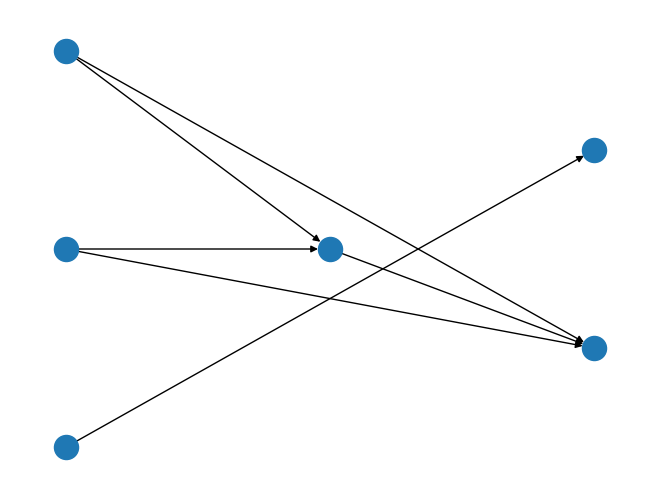

In [20]:
n_outputs = 2
n_inputs = 3
g = nx.DiGraph()
for name in range(-n_inputs, 0):
    g.add_node(name, node_type=0)
for name in winner.nodes.keys():
    if name < n_outputs:
        node_type = 2
    else:
        node_type = 1
    g.add_node(name, node_type=node_type)
for i,j in winner.connections.keys():
    g.add_edge(i, j)
pos = nx.multipartite_layout(g, subset_key="node_type")
nx.draw(g, pos=pos)